# Data Preprocessing Notebook

This notebook handles WAV/MIDI processing and DataFrame creation.
The output `music_df.pkl` will be used in the training notebook.

**This code imports essential libraries and modules needed for data preprocessing, including libraries for handling audio (e.g., `librosa`), MIDI processing (`pretty_midi`), data manipulation (`pandas`, `numpy`), machine learning utilities (`sklearn`), and PyTorch for deep learning. It also imports utilities for multithreading and operating system interactions.**

In [5]:

import gc
import os
import pickle
import time
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from pathlib import Path

import librosa
import librosa.display
import numpy as np
import pandas as pd
# import tables
import pretty_midi
import psutil
import torch
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset

# from tqdm.notebook import tqdm

**This code checks the PyTorch version, determines whether CUDA (GPU acceleration) is available, and prints the CUDA device name if detected. If CUDA is not available, it prints a message indicating that.**

In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA not detected!")

Torch version: 2.5.1+cu121
CUDA available: True
Device: NVIDIA GeForce RTX 4070 Ti SUPER


In [3]:
# Define the target subdirectory
subdirectory = Path("maestro-v3.0.0")

# Dictionary to hold files grouped by their base name
file_dict = defaultdict(dict)

# Traverse directory and collect files
for file in subdirectory.rglob('*'):
    if file.is_file():
        base_name = file.stem  # Filename without extension
        ext = file.suffix  # File extension (including dot, e.g., ".txt")
        file_dict[base_name][ext] = str(file)

# Convert dictionary to DataFrame

# Remove empty entries before making DataFrame
file_dict = {k: v for k, v in file_dict.items() if v}  # Keep only non-empty dicts
music_df = pd.DataFrame.from_dict(file_dict, orient='index')

# Display the DataFrame
music_df

,.midi,.wav
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...
MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_05_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_05_R1...
...,...,...
MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_2018_wav,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert4...,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert4...
MIDI-Unprocessed_Schubert4-6_MID--AUDIO_10_R2_2018_wav,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert4...,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert4...
MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert7...,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert7...
MIDI-Unprocessed_Schubert7-9_MID--AUDIO_15_R2_2018_wav,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert7...,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert7...


In [4]:
# Add columns for spectrogram and MIDI token sequence
# Add columns for extracted notes with timestamps
music_df["WAV_Notes"] = None
music_df["WAV_Timestamps"] = None
music_df["MIDI_Notes"] = None
music_df["MIDI_Timestamps"] = None

In [5]:
# Create a function to extract notes and timestamps from a WAV file
def extract_notes_from_wav(wav_path):
    """
    Extract active MIDI notes and their corresponding timestamps from a WAV file.

    This function processes an audio file to compute its Constant-Q Transform (CQT) and identifies
    the active notes based on their power in decibel scale. The active notes are converted to
    MIDI note numbers and their timestamps are calculated.

    Args:
        wav_path (str): Path to the WAV file to be processed.

    Returns:
        tuple:
            - active_notes (np.ndarray): Array of active MIDI note numbers.
            - timestamps (np.ndarray): Array of corresponding timestamps for the active notes.

    Notes:
        - The CQT is computed with frequencies corresponding to piano notes, starting from C1.
        - Notes are considered active if their power exceeds -20 dB.

    Example:
        >>> notes, times = extract_notes_from_wav("example.wav")
        >>> print("Notes:", notes)
        >>> print("Timestamps:", times)
    """
    # Load the audio file using Librosa
    # y: Audio time series data
    # sr: Sampling rate of the audio file
    y, sr = librosa.load(wav_path, sr=None)

    # Compute the Constant-Q Transform (CQT) of the audio signal
    # This provides a time-frequency representation
    cqt = np.abs(librosa.cqt(y, sr=sr))  # Take the magnitude of the CQT
    cqt_db = librosa.amplitude_to_db(cqt, ref=np.max)  # Convert to decibel scale

    # Define the minimum frequency (fmin) for the CQT frequency bins
    # Using C1 (the lowest note on the piano, approximately 32.7 Hz) as the starting frequency
    fmin = librosa.note_to_hz("C1")

    # Compute the frequencies corresponding to the CQT bins
    frequencies = librosa.cqt_frequencies(n_bins=cqt.shape[0], fmin=fmin)

    # Convert frame indices to time values
    times = librosa.frames_to_time(np.arange(cqt.shape[1]), sr=sr)

    # Convert the CQT frequencies to MIDI note numbers
    midi_numbers = librosa.hz_to_midi(frequencies)

    # Identify active notes based on a threshold in the decibel scale
    # Notes are considered active if their power exceeds -20 dB at any time
    active_notes = midi_numbers[(cqt_db > -20).any(axis=1)]
    timestamps = times[(cqt_db > -20).any(axis=0)]

    # Return the active MIDI notes and their corresponding timestamps
    return active_notes, timestamps

In [6]:
def extract_notes_from_midi(midi_path):
    """
    Extract MIDI notes and their corresponding timestamps from a given MIDI file.

    This function processes a MIDI file to retrieve the pitch (MIDI note numbers)
    and start times (timestamps) for each note. Notes and timestamps are returned
    as separate arrays.

    Args:
        midi_path (str): Path to the MIDI file to be processed.

    Returns:
        Tuple:
            - list: A list of unique MIDI note numbers (pitches).
            - list: A list of timestamps indicating the start times of the notes.

    Notes:
        - If the MIDI file cannot be parsed, the function returns (None, None).
        - Duplicate notes are removed from the returned list of notes.
    """
    try:
        # Load the MIDI file using pretty_midi
        midi_data = pretty_midi.PrettyMIDI(midi_path)

        notes = []  # List to store note pitches
        timestamps = []  # List to store timestamp of each note

        # Iterate over all instruments and their notes to extract data
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append(note.pitch)  # Append note pitch (as MIDI number)
                timestamps.append(note.start)  # Append note-on timestamp

        # Return unique notes and their corresponding timestamps
        return list(set(notes)), timestamps
    except:
        # In case of any error, return None for both notes and timestamps
        return None, None

In [7]:
# Define a function to process a single row
def process_row(index, row):
    result = {"index": index, "WAV_Notes": None, "WAV_Timestamps": None, "MIDI_Notes": None, "MIDI_Timestamps": None}

    # Process WAV files if they exist
    if '.wav' in row:
        notes, timestamps = extract_notes_from_wav(row['.wav'])
        result["WAV_Notes"] = notes
        result["WAV_Timestamps"] = timestamps

    # Process MIDI files if they exist
    if '.mid' in row or '.midi' in row:
        midi_file = row.get('.mid') or row.get('.midi')
        notes, timestamps = extract_notes_from_midi(midi_file)
        result["MIDI_Notes"] = notes
        result["MIDI_Timestamps"] = timestamps

    return result


# Use ThreadPoolExecutor to process rows in parallel
with ThreadPoolExecutor(max_workers=12) as executor:
    futures = [executor.submit(process_row, index, row) for index, row in music_df.iterrows()]
    for future in futures:
        row_result = future.result()
        # Update the DataFrame with results
        music_df.at[row_result["index"], "WAV_Notes"] = row_result["WAV_Notes"]
        music_df.at[row_result["index"], "WAV_Timestamps"] = row_result["WAV_Timestamps"]
        music_df.at[row_result["index"], "MIDI_Notes"] = row_result["MIDI_Notes"]
        music_df.at[row_result["index"], "MIDI_Timestamps"] = row_result["MIDI_Timestamps"]

In [8]:
# Save using Pickle (Python-specific)
music_df.to_pickle("music_data.pkl")

# Save using HDF5 (requires the PyTables library)
# music_df.to_hdf("music_data.h5", key="df", mode="w")


In [9]:
# music_df = pd.read_pickle("music_data.pkl")

In [10]:
music_df["WAV_Notes_Clean"] = music_df["WAV_Notes"].apply(
    lambda notes: [int(round(n)) for n in notes] if isinstance(notes, (list, np.ndarray)) else None
)

In [11]:
def rationalize_timestamps(timestamps, resolution=480, tempo=120):
    """
    Snap timestamps to nearest MIDI tick based on desired resolution and tempo.

    Args:
        timestamps (list or np.ndarray): List of float timestamps (seconds).
        resolution (int): MIDI ticks per quarter note (default 480).
        tempo (float): BPM for conversion (default 120 BPM).

    Returns:
        list[int]: Snapped ticks.
    """
    if not isinstance(timestamps, (list, np.ndarray)):
        return None
    ticks_per_second = (resolution * tempo) / 60.0
    return [round(t * ticks_per_second) for t in timestamps]

In [12]:
music_df["WAV_Timestamps_Snapped"] = music_df["WAV_Timestamps"].apply(rationalize_timestamps)
music_df["MIDI_Timestamps_Snapped"] = music_df["MIDI_Timestamps"].apply(rationalize_timestamps)

In [13]:
music_df["WAV_Timestamp_Real+Tick"] = music_df.apply(
    lambda row: list(zip(
        row["WAV_Timestamps"],
        rationalize_timestamps(row["WAV_Timestamps"])
    )) if isinstance(row["WAV_Timestamps"], (list, np.ndarray)) else None,
    axis=1
)


In [14]:
def midi_to_token_sequence(midi_path):
    """
    Converts a MIDI file into a sequence of tokenized note values with additional features.

    Args:
        midi_path (str): Path to the MIDI file.

    Returns:
        list: List of tokenized MIDI events [(pitch, velocity, duration, time_since_last_note)].
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        tokens = []

        for instrument in midi_data.instruments:
            previous_time = 0  # Track time of last note
            for note in instrument.notes:
                pitch = note.pitch  # MIDI note number (0-127)
                velocity = note.velocity  # How hard the note was pressed (0-127)
                duration = note.end - note.start  # Note duration in seconds
                time_since_last_note = note.start - previous_time  # Time since last note
                previous_time = note.start  # Update last note time

                tokens.append((pitch, velocity, duration, time_since_last_note))

        return tokens if tokens else None
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None


In [15]:
class MIDIVocabulary:
    def __init__(self,
                 pitch_classes=128,
                 velocity_bins=32,
                 duration_bins=64,
                 time_bins=64,
                 max_velocity=127,
                 max_duration=4.0,  # in seconds
                 max_time_gap=4.0):
        self.pitch_classes = pitch_classes
        self.velocity_bins = velocity_bins
        self.duration_bins = duration_bins
        self.time_bins = time_bins
        self.max_velocity = max_velocity
        self.max_duration = max_duration
        self.max_time_gap = max_time_gap

    def _quantize(self, value, bins, max_val):
        if value is None or not np.isfinite(value):
            return 0  # fallback/default bin
        bin_index = int((value / max_val) * bins)
        return max(0, min(bins - 1, bin_index))

    def encode(self, midi_tokens):
        """
        Converts raw tokens into bin indices: (pitch, velocity_bin, duration_bin, time_bin)
        """
        encoded_tokens = []
        for token in midi_tokens:
            if not isinstance(token, (tuple, list)) or len(token) < 4:
                raise ValueError(f"Malformed MIDI token: {token}")
            pitch, velocity, duration, time_gap = token
            pitch = int(pitch)
            velocity_bin = self._quantize(velocity, self.velocity_bins, self.max_velocity)
            duration_bin = self._quantize(duration, self.duration_bins, self.max_duration)
            time_bin = self._quantize(time_gap, self.time_bins, self.max_time_gap)
            encoded_tokens.append((pitch, velocity_bin, duration_bin, time_bin))
        return encoded_tokens

In [16]:
# Ensure the necessary columns exist and explicitly set dtype to 'object'
for col in ["MIDI_Tokens", "Encoded_MIDI_Tokens"]:
    if col not in music_df.columns:
        music_df[col] = None
    else:
        music_df[col] = music_df[col].astype("object")  # Ensure proper type

midi_vocab = MIDIVocabulary()  # Create an instance


def process_midi(midi_path):
    """
    Wrapper function to process MIDI files, extract tokens, and encode them.
    Returns a tuple: (raw MIDI tokens, encoded MIDI tokens).
    """
    midi_tokens = midi_to_token_sequence(midi_path)  # Extract raw MIDI tokens
    encoded_tokens = midi_vocab.encode(midi_tokens) if midi_tokens else None  # Encode if valid tokens exist
    return midi_tokens, encoded_tokens  # Store both


# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=12) as executor:  # Adjust max_workers as needed
    futures = {executor.submit(process_midi, row[".midi"]): idx for idx, row in music_df.iterrows() if
               pd.notna(row[".midi"])}

    # Collect results and store them in the DataFrame
    for future in as_completed(futures):
        idx = futures[future]
        try:
            raw_tokens, encoded_tokens = future.result()  # Get processed tokens

            # Ensure lists are stored properly as objects to avoid NumPy conversion errors
            music_df.at[idx, "MIDI_Tokens"] = raw_tokens if raw_tokens is None else list(raw_tokens)
            music_df.at[idx, "Encoded_MIDI_Tokens"] = encoded_tokens if encoded_tokens is None else list(encoded_tokens)

        except Exception as e:
            print(f"Error processing MIDI file at row {idx}: {e}")

#  Explicitly convert columns to object type again to be safe
music_df["MIDI_Tokens"] = music_df["MIDI_Tokens"].astype("object")
music_df["Encoded_MIDI_Tokens"] = music_df["Encoded_MIDI_Tokens"].astype("object")

# Print to verify
print(music_df.head())  # Display the first few rows
print(f"Processed {music_df['MIDI_Tokens'].notnull().sum()} MIDI files successfully.")


                                                                                                .midi  \
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID-...  maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...   
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID-...  maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...   
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID-...  maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...   
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID-...  maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...   
MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AU...  maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_05_R1...   

                                                                                                 .wav  \
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID-...  maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...   
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID-...  maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...   
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID-...  ma

In [17]:
music_df

,.midi,.wav,WAV_Notes,WAV_Timestamps,MIDI_Notes,MIDI_Timestamps,WAV_Notes_Clean,WAV_Timestamps_Snapped,MIDI_Timestamps_Snapped,WAV_Timestamp_Real+Tick,MIDI_Tokens,Encoded_MIDI_Tokens
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,"[36.0, 37.0, 37.99999999999999, 38.99999999999...","[1.1145578231292517, 1.1261678004535147, 1.137...","[38, 40, 41, 42, 43, 45, 47, 48, 49, 50, 51, 5...","[1.0927083333333334, 1.2791666666666666, 1.463...","[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...","[1070, 1081, 1092, 1103, 1148, 1159, 1170, 118...","[1049, 1228, 1405, 1568, 1237, 1715, 1731, 190...","[(1.1145578231292517, 1070), (1.12616780045351...","[(71, 60, 0.09687499999999982, 1.0927083333333...","[(71, 15, 1, 17), (55, 11, 3, 2), (59, 13, 2, ..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,"[34.0, 34.99999999999999, 36.0, 37.0, 37.99999...","[1.195827664399093, 1.207437641723356, 1.21904...","[24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 3...","[1.040625, 1.0322916666666666, 1.1427083333333...","[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[1148, 1159, 1170, 1181, 1193, 1204, 1215, 122...","[999, 991, 1097, 1099, 1168, 1160, 1276, 1279,...","[(1.195827664399093, 1148), (1.207437641723356...","[(31, 36, 0.06562500000000004, 1.040625), (43,...","[(31, 9, 1, 16), (43, 10, 1, 0), (44, 11, 1, 1..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,"[34.0, 34.99999999999999, 36.0, 37.99999999999...","[2.0317460317460316, 2.043356009070295, 2.0549...","[24, 26, 28, 29, 31, 34, 35, 36, 37, 38, 39, 4...","[1.0229166666666667, 1.2708333333333333, 1.496...","[34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 4...","[1950, 1962, 1973, 1984, 2407, 2419, 2430, 244...","[982, 1220, 1437, 1778, 2030, 2026, 2070, 2236...","[(2.0317460317460316, 1950), (2.04335600907029...","[(38, 37, 0.3041666666666667, 1.02291666666666...","[(38, 9, 4, 16), (45, 10, 2, 3), (53, 13, 1, 3..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,"[34.99999999999999, 36.0, 37.0, 37.99999999999...","[1.0681179138321995, 1.0797278911564625, 1.091...","[24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1.0625, 1.0604166666666666, 1.058333333333333...","[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 4...","[1025, 1037, 1048, 1059, 1070, 1081, 1092, 110...","[1020, 1018, 1016, 1368, 1363, 1358, 1370, 136...","[(1.0681179138321995, 1025), (1.07972789115646...","[(31, 90, 0.043749999999999956, 1.0625), (43, ...","[(31, 22, 0, 17), (43, 25, 0, 0), (55, 24, 0, ..."
MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_05_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_05_R1...,"[34.0, 34.99999999999999, 36.0, 37.0, 37.99999...","[2.159455782312925, 2.1710657596371883, 2.1826...","[25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[0.9864583333333333, 1.6375, 1.183333333333333...","[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[2073, 2084, 2095, 2107, 2118, 2129, 2140, 215...","[947, 1572, 1136, 1581, 1793, 1778, 1964, 2017...","[(2.159455782312925, 2073), (2.171065759637188...","[(32, 19, 0.24062499999999998, 0.9864583333333...","[(32, 4, 3, 15), (51, 6, 3, 10), (75, 11, 10, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_2018_wav,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert4...,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert4...,"[34.0, 37.99999999999999, 38.999999999999986, ...","[4.469333333333333, 4.48, 4.490666666666667, 4...","[28, 29,

In [18]:
music_df.to_pickle("music_data.pkl")

In [3]:
music_df = pd.read_pickle("music_data.pkl")

In [20]:
def snap_to_fraction(timestamps, resolution=480, tempo=120):
    """
    Convert float timestamps into rational fractions of MIDI ticks.
    """
    if not isinstance(timestamps, (list, np.ndarray)):
        return None
    ticks_per_second = Fraction(resolution * tempo, 60)
    return [Fraction(str(t)) * ticks_per_second for t in timestamps]


In [21]:
symbolic_df = pd.DataFrame()
symbolic_df["MIDI_Notes"] = music_df["MIDI_Notes"]
symbolic_df["MIDI_Timestamps_Fraction"] = music_df["MIDI_Timestamps"].apply(snap_to_fraction)
symbolic_df.to_pickle("symbolic_midi_data.pkl")
symbolic_df["MIDI_Ticks"] = symbolic_df["MIDI_Timestamps_Fraction"].apply(lambda ts: [int(round(t)) for t in ts] if ts else None)

In [22]:
symbolic_df.to_pickle("symbolic_midi_data.pkl")
symbolic_df

,MIDI_Notes,MIDI_Timestamps_Fraction,MIDI_Ticks
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav,"[38, 40, 41, 42, 43, 45, 47, 48, 49, 50, 51, 5...","[16390625000000001/15625000000000, 19187499999...","[1049, 1228, 1405, 1568, 1237, 1715, 1731, 190..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav,"[24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 3...","[999, 15484374999999999/15625000000000, 857031...","[999, 991, 1097, 1099, 1168, 1160, 1276, 1279,..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav,"[24, 26, 28, 29, 31, 34, 35, 36, 37, 38, 39, 4...","[30687500000000001/31250000000000, 38124999999...","[982, 1220, 1437, 1778, 2030, 2026, 2070, 2236..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav,"[24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1020, 15906249999999999/15625000000000, 31749...","[1020, 1018, 1016, 1368, 1363, 1358, 1370, 136..."
MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav,"[25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[29593749999999999/31250000000000, 1572, 35499...","[947, 1572, 1136, 1581, 1793, 1778, 1964, 2017..."
...,...,...,...
MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_2018_wav,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...","[6015624999999999/6250000000000, 1995/2, 31914...","[962, 998, 1021, 1010, 986, 1536, 1894, 1935, ..."
MIDI-Unprocessed_Schubert4-6_MID--AUDIO_10_R2_2018_wav,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...","[31445312499999999/31250000000000, 32851562499...","[1006, 1051, 984, 971, 960, 1410, 1791, 1832, ..."
MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav,"[26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...","[9589843749999999/15625000000000, 191406249999...","[614, 612, 619, 611, 612, 2021, 2032, 2025, 20..."
MIDI-Unprocessed_Schubert7-9_MID--AUDIO_15_R2_2018_wav,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...","[3945/4, 30507812499999999/31250000000000, 307...","[986, 976, 984, 994, 966, 3256, 3271, 3256, 32..."


In [23]:
music_df

,.midi,.wav,WAV_Notes,WAV_Timestamps,MIDI_Notes,MIDI_Timestamps,WAV_Notes_Clean,WAV_Timestamps_Snapped,MIDI_Timestamps_Snapped,WAV_Timestamp_Real+Tick,MIDI_Tokens,Encoded_MIDI_Tokens
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,"[36.0, 37.0, 37.99999999999999, 38.99999999999...","[1.1145578231292517, 1.1261678004535147, 1.137...","[38, 40, 41, 42, 43, 45, 47, 48, 49, 50, 51, 5...","[1.0927083333333334, 1.2791666666666666, 1.463...","[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...","[1070, 1081, 1092, 1103, 1148, 1159, 1170, 118...","[1049, 1228, 1405, 1568, 1237, 1715, 1731, 190...","[(1.1145578231292517, 1070), (1.12616780045351...","[(71, 60, 0.09687499999999982, 1.0927083333333...","[(71, 15, 1, 17), (55, 11, 3, 2), (59, 13, 2, ..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,"[34.0, 34.99999999999999, 36.0, 37.0, 37.99999...","[1.195827664399093, 1.207437641723356, 1.21904...","[24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 3...","[1.040625, 1.0322916666666666, 1.1427083333333...","[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[1148, 1159, 1170, 1181, 1193, 1204, 1215, 122...","[999, 991, 1097, 1099, 1168, 1160, 1276, 1279,...","[(1.195827664399093, 1148), (1.207437641723356...","[(31, 36, 0.06562500000000004, 1.040625), (43,...","[(31, 9, 1, 16), (43, 10, 1, 0), (44, 11, 1, 1..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,"[34.0, 34.99999999999999, 36.0, 37.99999999999...","[2.0317460317460316, 2.043356009070295, 2.0549...","[24, 26, 28, 29, 31, 34, 35, 36, 37, 38, 39, 4...","[1.0229166666666667, 1.2708333333333333, 1.496...","[34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 4...","[1950, 1962, 1973, 1984, 2407, 2419, 2430, 244...","[982, 1220, 1437, 1778, 2030, 2026, 2070, 2236...","[(2.0317460317460316, 1950), (2.04335600907029...","[(38, 37, 0.3041666666666667, 1.02291666666666...","[(38, 9, 4, 16), (45, 10, 2, 3), (53, 13, 1, 3..."
MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1...,"[34.99999999999999, 36.0, 37.0, 37.99999999999...","[1.0681179138321995, 1.0797278911564625, 1.091...","[24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[1.0625, 1.0604166666666666, 1.058333333333333...","[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 4...","[1025, 1037, 1048, 1059, 1070, 1081, 1092, 110...","[1020, 1018, 1016, 1368, 1363, 1358, 1370, 136...","[(1.0681179138321995, 1025), (1.07972789115646...","[(31, 90, 0.043749999999999956, 1.0625), (43, ...","[(31, 22, 0, 17), (43, 25, 0, 0), (55, 24, 0, ..."
MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_05_R1...,maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_05_R1...,"[34.0, 34.99999999999999, 36.0, 37.0, 37.99999...","[2.159455782312925, 2.1710657596371883, 2.1826...","[25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[0.9864583333333333, 1.6375, 1.183333333333333...","[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[2073, 2084, 2095, 2107, 2118, 2129, 2140, 215...","[947, 1572, 1136, 1581, 1793, 1778, 1964, 2017...","[(2.159455782312925, 2073), (2.171065759637188...","[(32, 19, 0.24062499999999998, 0.9864583333333...","[(32, 4, 3, 15), (51, 6, 3, 10), (75, 11, 10, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_2018_wav,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert4...,maestro-v3.0.0\2018\MIDI-Unprocessed_Schubert4...,"[34.0, 37.99999999999999, 38.999999999999986, ...","[4.469333333333333, 4.48, 4.490666666666667, 4...","[28, 29,

In [6]:
# Ensure required directories exist
# Directory to cache spectrogram tensors
spectrogram_cache_dir = "spectrogram_cache"

# Directory to cache spectrogram images
image_cache_dir = "spectrogram_images"

# Ensure the directories exist or create them if they don't
os.makedirs(spectrogram_cache_dir, exist_ok=True)
os.makedirs(image_cache_dir, exist_ok=True)


def process_wav_to_spectrogram(wav_file_path, file_index, device, bins_per_octave=24, n_bins=192, hop_length=256):
    """
    Converts a WAV file into a multi-view spectrogram tensor and saves it to disk.

    Args:
        wav_file_path (str): Path to the input WAV file.
        file_index (int): Index representing the specific file being processed (used for caching).
        device (torch.device): Device (CPU or GPU) to perform computations on.
        bins_per_octave (int): Number of frequency bins per octave (default = 24).
        n_bins (int): Total number of frequency bins (default = 192).
        hop_length (int): Hop length for the spectrogram calculation (default = 256).

    Returns:
        tuple: (str or None, None)
        - Path to the saved spectrogram file if successful, None otherwise.

    Raises:
        Exception: Handles exceptions during processing and returns (None, None).
    """
    try:
        audio_signal, sample_rate = librosa.load(wav_file_path, sr=None)
        if np.all(audio_signal == 0):
            print(f"⚠️ Silent audio detected: {wav_file_path}")
            return None, None

        # Normalize and pre-process
        audio_signal = torch.tensor(audio_signal, dtype=torch.float32, device=device)
        audio_signal = audio_signal / (torch.max(torch.abs(audio_signal)) + 1e-6)

        # Loudness normalization
        import pyloudnorm as pyln
        loudness_meter = pyln.Meter(sample_rate)
        audio_signal_np = audio_signal.cpu().numpy()
        integrated_loudness = loudness_meter.integrated_loudness(audio_signal_np)
        audio_signal_np = pyln.normalize.loudness(audio_signal_np, integrated_loudness, -27.0)

        # Back to torch
        audio_signal = torch.tensor(audio_signal_np, dtype=torch.float32, device=device)
        audio_signal = torch.clamp(audio_signal, -0.85, 0.85)

        # Pre-emphasis
        audio_signal_np = librosa.effects.preemphasis(audio_signal.cpu().numpy())
        audio_signal = torch.tensor(audio_signal_np, dtype=torch.float32, device=device)

        # Harmonic/Percussive separation
        harmonic_signal, percussive_signal = librosa.effects.hpss(audio_signal.cpu().numpy())
        harmonic_signal, percussive_signal = torch.tensor(harmonic_signal), torch.tensor(percussive_signal)

        def normalize_to_db(spectrogram):
            """
            Normalizes a given spectrogram to dB scale between 0 and 1.

            Args:
                spectrogram (np.ndarray): Input spectrogram to normalize.

            Returns:
                np.ndarray: Normalized spectrogram.
            """
            db_values = librosa.amplitude_to_db(spectrogram, ref=np.max)
            return (db_values - db_values.min()) / (db_values.max() - db_values.min() + 1e-6)

        # === Spectrogram Features ===
        spectrogram_features = [
            normalize_to_db(np.abs(librosa.cqt(harmonic_signal.numpy(), sr=sample_rate, hop_length=hop_length, n_bins=n_bins, bins_per_octave=bins_per_octave))),
            normalize_to_db(np.abs(librosa.cqt(percussive_signal.numpy(), sr=sample_rate, hop_length=hop_length, n_bins=n_bins, bins_per_octave=bins_per_octave))),
            normalize_to_db(librosa.feature.melspectrogram(y=audio_signal.cpu().numpy(), sr=sample_rate, hop_length=hop_length, n_mels=128)),
            normalize_to_db(librosa.feature.mfcc(y=audio_signal.cpu().numpy(), sr=sample_rate, n_mfcc=20)),
            normalize_to_db(librosa.feature.chroma_cqt(y=audio_signal.cpu().numpy(), sr=sample_rate, hop_length=hop_length)),
            normalize_to_db(librosa.feature.spectral_contrast(y=audio_signal.cpu().numpy(), sr=sample_rate, hop_length=hop_length)),
            normalize_to_db(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_signal.cpu().numpy()), sr=sample_rate)),
            normalize_to_db(librosa.feature.rms(y=audio_signal.cpu().numpy())),
            normalize_to_db(librosa.feature.zero_crossing_rate(audio_signal.cpu().numpy())),
            normalize_to_db(librosa.onset.onset_strength(y=audio_signal.cpu().numpy(), sr=sample_rate, hop_length=hop_length).reshape(1, -1)),  # reshape to 2D
            normalize_to_db(librosa.feature.tempogram(y=audio_signal.cpu().numpy(), sr=sample_rate, hop_length=hop_length)),
        ]

        # Align time dimension
        min_time_dim = min(feature.shape[1] for feature in spectrogram_features)
        spectrogram_features = [feature[:, :min_time_dim] for feature in spectrogram_features]

        # Pad frequency dimension
        max_freq_bins = max(feature.shape[0] for feature in spectrogram_features)
        spectrogram_features = [np.pad(feature, ((0, max_freq_bins - feature.shape[0]), (0, 0)), mode='constant') for feature in spectrogram_features]

        # Stack all together: shape → [channels, freq_bins, time_steps]
        spectrogram_tensor = torch.tensor(np.stack(spectrogram_features), dtype=torch.float32)

        # Save
        spectrogram_path = os.path.join(spectrogram_cache_dir, f"{file_index}.pkl")
        with open(spectrogram_path, "wb") as file:
            pickle.dump(spectrogram_tensor, file)

        # Cleanup
        del audio_signal, harmonic_signal, percussive_signal, spectrogram_features, spectrogram_tensor
        time.sleep(1.0)
        torch.cuda.empty_cache()
        gc.collect()

        return spectrogram_path, None

    except Exception as error:
        print(f"❌ Error processing {wav_file_path}: {error}")
        torch.cuda.empty_cache()
        gc.collect()
        return None, None

In [25]:
empty_rows = music_df.isna().all(axis=1)  # Find rows where all columns are NaN
print(f"Number of fully empty rows: {empty_rows.sum()}")
print(music_df[empty_rows])  # Display problematic rows
print(music_df[[".midi", ".wav"]].isna().sum())

Number of fully empty rows: 0
Empty DataFrame
Columns: [.midi, .wav, WAV_Notes, WAV_Timestamps, MIDI_Notes, MIDI_Timestamps, WAV_Notes_Clean, WAV_Timestamps_Snapped, MIDI_Timestamps_Snapped, WAV_Timestamp_Real+Tick, MIDI_Tokens, Encoded_MIDI_Tokens]
Index: []
.midi    0
.wav     0
dtype: int64


In [26]:
music_df = music_df.dropna(how="all")

In [27]:
empty_rows = music_df.isna().all(axis=1)  # Find rows where all columns are NaN
print(f"Number of fully empty rows: {empty_rows.sum()}")
print(music_df[empty_rows])  # Display problematic rows
print(music_df[[".midi", ".wav"]].isna().sum())

Number of fully empty rows: 0
Empty DataFrame
Columns: [.midi, .wav, WAV_Notes, WAV_Timestamps, MIDI_Notes, MIDI_Timestamps, WAV_Notes_Clean, WAV_Timestamps_Snapped, MIDI_Timestamps_Snapped, WAV_Timestamp_Real+Tick, MIDI_Tokens, Encoded_MIDI_Tokens]
Index: []
.midi    0
.wav     0
dtype: int64


In [ ]:
# Directories
spectrogram_cache_dir = Path("spectrogram_cache")
image_cache_dir = Path("spectrogram_images")
spectrogram_cache_dir.mkdir(exist_ok=True)
image_cache_dir.mkdir(exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memory control
initial_batch_size = 10
min_batch_size = 10
memory_threshold = 0.8
recovery_threshold = 0.3
max_workers = 12

# Output paths
spectrogram_paths, image_paths = [], []

def get_available_ram():
    return psutil.virtual_memory().available / psutil.virtual_memory().total

def validate_spectrogram(path):
    """Try loading the spectrogram. Return True if it succeeds and looks valid."""
    try:
        with open(path, "rb") as f:
            obj = pickle.load(f)
        if isinstance(obj, torch.Tensor) and obj.ndim >= 2:
            return True
        else:
            return False
    except Exception as e:
        print(f"❌ Validation failed for {path}: {e}")
        return False

def scan_and_fix_spectrogram_cache(music_df):
    """
    Check all spectrogram_cache files and fix invalid ones by forcing reprocessing.
    Updates the DataFrame `Spectrogram_Path` accordingly.
    """
    print("🔍 Scanning spectrogram cache for invalid files...")
    bad_files = []

    for idx, row in music_df.iterrows():
        tensor_path = Path(row.get("Spectrogram_Path", ""))
        if tensor_path.is_file():
            if not validate_spectrogram(tensor_path):
                bad_files.append(idx)
                try:
                    tensor_path.unlink()
                    print(f"🗑️ Deleted corrupt spectrogram at {tensor_path}")
                except Exception as e:
                    print(f"⚠️ Failed to delete {tensor_path}: {e}")
        else:
            # If spectrogram path is missing
            bad_files.append(idx)

    print(f"✅ Scan complete. Found {len(bad_files)} bad or missing spectrograms.")

    return bad_files  # Return indices that need regeneration

def regenerate_spectrograms(music_df, bad_indices):
    """
    Regenerate missing/corrupt spectrograms for the given indices.
    """
    print(f"🔄 Regenerating {len(bad_indices)} missing/corrupt spectrograms...")
    batch_size = initial_batch_size
    i = 0

    bad_rows = music_df.loc[bad_indices]

    while i < len(bad_rows):
        available_ram = get_available_ram()
        if available_ram < memory_threshold and batch_size > min_batch_size:
            batch_size = max(min_batch_size, int(batch_size * 0.8))
            print(f"⚠️ High memory usage detected! Reducing batch size to {batch_size}")
        elif available_ram > recovery_threshold and batch_size < initial_batch_size:
            batch_size = min(initial_batch_size, int(batch_size * 1.1))
            print(f"✅ Memory recovered. Increasing batch size to {batch_size}")

        batch = bad_rows.iloc[i: i + batch_size]
        paths, img_paths = [], []

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_index = {}
            for idx, row in batch.iterrows():
                wav_path = row.get(".wav")
                if pd.isna(wav_path):
                    print(f"⚠️ Skipping {idx} — no WAV file available.")
                    continue
                future = executor.submit(process_wav_to_spectrogram, wav_path, idx, device)
                future_to_index[future] = idx

            for future in as_completed(future_to_index):
                idx = future_to_index[future]
                try:
                    tensor_path, image_path = future.result()
                    music_df.at[idx, "Spectrogram_Path"] = tensor_path
                    music_df.at[idx, "Spectrogram_Image"] = image_path
                    print(f"✅ Regenerated spectrogram for {idx}")
                except Exception as e:
                    print(f"❌ Failed to regenerate {idx}: {e}")

        del batch, future_to_index, paths, img_paths
        torch.cuda.empty_cache()
        gc.collect()
        i += batch_size
        time.sleep(0.5)

    print("🏁 Regeneration complete.")

# === MAIN REPAIR FLOW ===

# Step 1: Scan and find bad/missing spectrograms
bad_indices = scan_and_fix_spectrogram_cache(music_df)

# Step 2: If bad ones exist, fix them automatically
if bad_indices:
    regenerate_spectrograms(music_df, bad_indices)
else:
    print("🎯 No missing or corrupt spectrograms to fix!")

# Step 3: Save updated DataFrame
music_df.to_pickle("music_df_fixed.pkl")
print("💾 Saved repaired DataFrame to music_df_fixed.pkl")

🔍 Scanning spectrogram cache for invalid files...
✅ Scan complete. Found 1276 bad or missing spectrograms.
🔄 Regenerating 1276 missing/corrupt spectrograms...


In [6]:
spectrogram_dir = Path("spectrogram_cache")  # Adjust if different
bad_spectrograms = []

def validate_spectrogram(path):
    try:
        with open(path, "rb") as f:
            spec = pickle.load(f)
        if not isinstance(spec, torch.Tensor):
            print(f"❌ Not a tensor: {path}")
            return False
        if spec.ndim != 3:
            print(f"❌ Not 3D tensor: {spec.shape} - {path}")
            return False
        if spec.shape[0] != 11:
            print(f"❌ Wrong channel count {spec.shape[0]} != 11 - {path}")
            return False
        return True
    except Exception as e:
        print(f"❌ Failed loading {path}: {e}")
        return False

# Scan all .pkl spectrograms
for file in spectrogram_dir.glob("*.pkl"):
    if not validate_spectrogram(file):
        bad_spectrograms.append(file)

print(f"\n🔎 Found {len(bad_spectrograms)} bad spectrogram files out of {len(list(spectrogram_dir.glob('*.pkl')))} total.")


🔎 Found 0 bad spectrogram files out of 1276 total.


In [29]:
music_df.to_pickle("music_data.pkl")

In [30]:
# Add a new column 'Seq_Length' representing the length of MIDI token sequences
music_df["Seq_Length"] = music_df["Encoded_MIDI_Tokens"].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [31]:
music_df.to_pickle("music_data_with_lengths.pkl")

In [32]:
def collate_fn(batch):
    """Pads MIDI sequences and stacks spectrograms for batching."""
    spectrograms, midi_tokens = zip(*batch)

    # 🔹 Ensure MIDI tokens are lists (for padding compatibility)
    midi_tokens = [torch.tensor(seq, dtype=torch.long) if isinstance(seq, (list, np.ndarray)) else torch.tensor([0]) for
                   seq in midi_tokens]

    # 🔹 Pad MIDI sequences to the max length in batch
    midi_tokens_padded = pad_sequence(midi_tokens, batch_first=True, padding_value=0)

    # 🔹 Ensure spectrograms have the same shape before stacking
    try:
        spectrograms = torch.stack(spectrograms)  # Shape: (B, 6, Freq, Time)
    except RuntimeError as e:
        print(f"Error stacking spectrograms: {e}")
        return None, None

    return spectrograms, midi_tokens_padded


In [33]:
class MaestroDataset(Dataset):
    def __init__(self, df):
        # Drop rows with missing spectrogram paths or encoded MIDI tokens
        self.df = df.dropna(subset=["Spectrogram_Path", "Encoded_MIDI_Tokens"])

    def __len__(self):
        # Return the number of valid rows in the DataFrame
        return len(self.df)

    def __getitem__(self, idx):
        # Retrieve the row at the given index
        row = self.df.iloc[idx]

        # Load the spectrogram from the given path
        spectrogram_path = row["Spectrogram_Path"]
        if not spectrogram_path or not os.path.exists(spectrogram_path):
            print(f"Warning: Missing spectrogram file {spectrogram_path}")
            return None  # Handle missing spectrogram files

        try:
            with open(spectrogram_path, "rb") as f:
                spectrogram = pickle.load(f)
            # Ensure the spectrogram is a torch tensor
            if not isinstance(spectrogram, torch.Tensor):
                spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading spectrogram {spectrogram_path}: {e}")
            return None

        # Load and validate MIDI tokens
        midi_tokens = row["Encoded_MIDI_Tokens"]
        if isinstance(midi_tokens, list):
            midi_tokens = torch.tensor(midi_tokens, dtype=torch.long)
        else:
            print(f"Warning: Invalid MIDI tokens at index {idx}")
            # Default to an empty token if invalid
            midi_tokens = torch.tensor([0], dtype=torch.long)

        return spectrogram, midi_tokens

In [34]:
# Save the DataFrame for later use in training
music_df.to_pickle("music_df.pkl")
print("✅ DataFrame saved as music_df.pkl")


✅ DataFrame saved as music_df.pkl


In [35]:
# Bin sequence lengths into quantiles and assign them to a new column
music_df["Length_Bin"] = pd.qcut(music_df["Seq_Length"], q=10, duplicates="drop")

# Split the dataset into training (70%), validation (10%) and testing (20%) sets, stratified by sequence length bins
train_df, temp_df = train_test_split(
    music_df,
    test_size=0.3,  # 30% goes to val + test
    stratify=music_df["Length_Bin"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=2/3,  # 2/3 of temp = 20% of original
    stratify=temp_df["Length_Bin"],
    random_state=42,
)


# Save the training and testing datasets to separate pickle files
train_df.to_pickle("train_split.pkl")
val_df.to_pickle("val_split.pkl")
test_df.to_pickle("test_split.pkl")

In [36]:
# Open a file to save dataset splitting information
with open("data_split_info.txt", "w") as f:
    # Write the number of training samples to the file
    f.write(f"Train samples: {len(train_df)}\n")
    # Write the number of testing samples to the file
    f.write(f"Test samples: {len(test_df)}\n")
    # Write the distribution of sequence length bins to the file
    f.write(f"Bins:\n{music_df['Length_Bin'].value_counts().sort_index()}")

In [37]:
# Load the training dataset from the pickle file
df = pd.read_pickle("train_split.pkl")

# Filter rows where 'Spectrogram_Path' or 'Encoded_MIDI_Tokens' are missing
bad_rows = df[df["Spectrogram_Path"].isnull() | df["Encoded_MIDI_Tokens"].isnull()]

# Display the count of problematic rows in the training set
print(f"⚠️ Bad samples in training set: {len(bad_rows)}")

# Print details of the problematic rows including MIDI and WAV paths
print(bad_rows[[".midi", ".wav", "Spectrogram_Path"]])

⚠️ Bad samples in training set: 0
Empty DataFrame
Columns: [.midi, .wav, Spectrogram_Path]
Index: []


In [38]:
df = df.dropna(subset=["Spectrogram_Path", "Encoded_MIDI_Tokens"])

In [39]:
# Function to fetch the spectrogram length from a file
def get_spec_length(path):
    try:
        # Open the file in binary read mode and load its contents
        with open(path, "rb") as f:
            return pickle.load(f).shape[-1]  # Return the last dimension of the spectrogram
    except:
        # Return 0 if an error occurs (e.g., file not found or corrupted)
        return 0


# Add a new column 'Spec_Length' by applying the function to each Spectrogram_Path
df["Spec_Length"] = df["Spectrogram_Path"].apply(get_spec_length)

# Save the updated DataFrame with the new column to a pickle file
df.to_pickle("train_split_with_spec_len.pkl")

In [40]:
# Delete DataFrames from memory to free up resources
del music_df, train_df, test_df, val_df, bad_rows

# Manually trigger garbage collection to clean up unused objects
gc.collect()

# Clear CUDA memory to avoid memory leaks or overflow on GPU
torch.cuda.empty_cache()

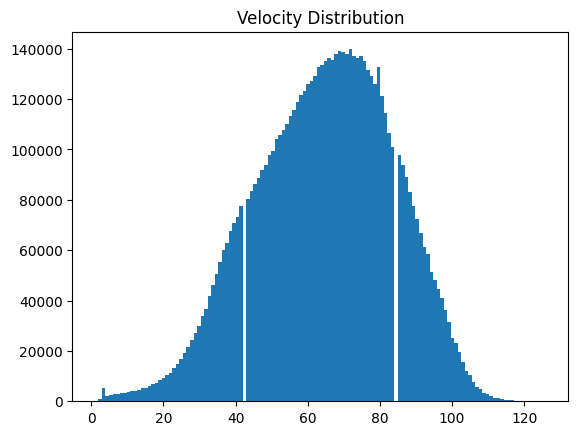

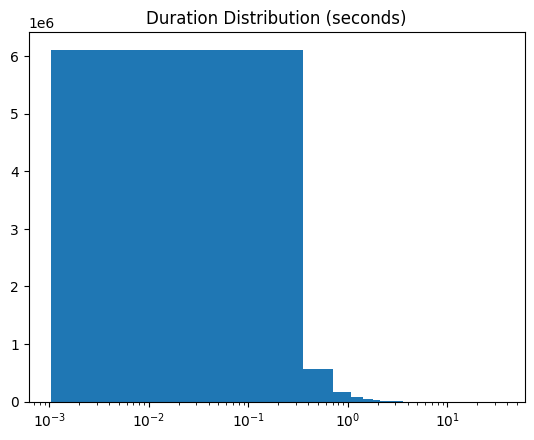

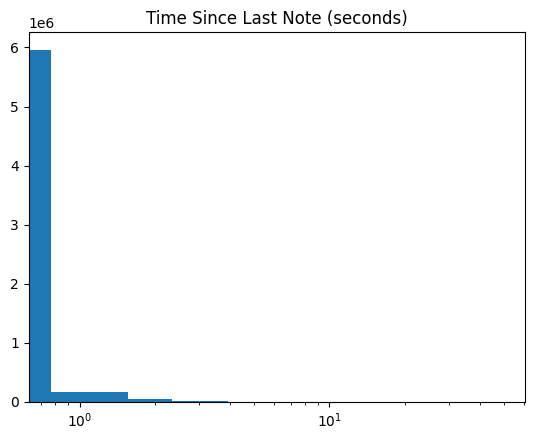

In [42]:
import matplotlib.pyplot as plt
music_df = pd.read_pickle("music_df.pkl")
velocities = []
durations = []
time_gaps = []

for tokens in music_df["MIDI_Tokens"]:
    if tokens:
        for pitch, velocity, duration, gap in tokens:
            velocities.append(velocity)
            durations.append(duration)
            time_gaps.append(gap)

plt.hist(velocities, bins=128)
plt.title("Velocity Distribution")
plt.show()

plt.hist(durations, bins=100)
plt.title("Duration Distribution (seconds)")
plt.xscale("log")
plt.show()

plt.hist(time_gaps, bins=100)
plt.title("Time Since Last Note (seconds)")
plt.xscale("log")
plt.show()

In [ ]:
class Quantizer:
    def __init__(
        self,
        velocity_bins=32,
        duration_bins=64,
        duration_range=(0.01, 10.0),
        time_bins=32,
        time_range=(0.01, 8.0),
    ):
        self.velocity_bins = velocity_bins
        self.duration_bins = duration_bins
        self.time_bins = time_bins

        # Velocity edges are implicit (fixed-width)
        self.velocity_bin_size = 128 / velocity_bins

        # Log-space bins for duration and time
        self.duration_edges = np.logspace(np.log10(duration_range[0]), np.log10(duration_range[1]), num=duration_bins + 1)
        self.time_edges = np.logspace(np.log10(time_range[0]), np.log10(time_range[1]), num=time_bins + 1)

    def velocity_bin(self, velocity):
        """Quantize velocity [0–127] into bins."""
        bin_idx = int(velocity // self.velocity_bin_size)
        return min(bin_idx, self.velocity_bins - 1)

    def duration_bin(self, duration_sec):
        """Quantize duration (in seconds) into log-spaced bins."""
        bin_idx = np.digitize(duration_sec, self.duration_edges) - 1
        return int(np.clip(bin_idx, 0, self.duration_bins - 1))

    def time_bin(self, time_sec):
        """Quantize time since the last note (in seconds) into log-spaced bins."""
        bin_idx = np.digitize(time_sec, self.time_edges) - 1
        return int(np.clip(bin_idx, 0, self.time_bins - 1))

    def inverse_velocity(self, bin_idx):
        """Approximate original velocity from bin."""
        return int((bin_idx + 0.5) * self.velocity_bin_size)

    def inverse_duration(self, bin_idx):
        """Approximate original duration (seconds) from bin."""
        bin_idx = np.clip(bin_idx, 0, self.duration_bins - 1)
        return float((self.duration_edges[bin_idx] + self.duration_edges[bin_idx + 1]) / 2)

    def inverse_time(self, bin_idx):
        """Approximate original time gap (seconds) from bin."""
        bin_idx = np.clip(bin_idx, 0, self.time_bins - 1)
        return float((self.time_edges[bin_idx] + self.time_edges[bin_idx + 1]) / 2)